In [93]:
import pandas as pd
import numpy as np
import math
%load_ext autoreload

In [394]:
"""Let's define the model here"""
c_x = np.array([1,2])
s_x = np.array([0.5,0.7])
c_t = np.array([0.5])
s_t = np.array([1])
c_yz = np.array([0.6])
c_yt = np.array([1])
s_y = np.array([1])
#num_samples = 1000
#df = linear_data_df(num_samples, c_x, c_t, c_yz, c_yt, s_x, s_t, s_y)

In [395]:
from lineardatamodels import *
from lineartoydata import *
from lineardatatools import *

In [418]:
"""Run this before the first time running the next cell"""
datasizes = [100,200,500,1000,2000]
i = 0
j = 0
dfs = [[0 for j in range(10)] for i in range(len(datasizes))]
models = [[0 for j in range(10)] for i in range(len(datasizes))]

In [419]:
"""Runs the model for different datasets multiple times"""
%autoreload 2
BATCH_SIZE = 100
datasize_times = 10
device = 'cpu'

#Simulating datasets and training models
while i < len(datasizes):
    while j < datasize_times:
        num_samples = datasizes[i]
        print("Training data size {}, run {}".format(num_samples, j+1))
        df = linear_data_df(num_samples, c_x, c_t, c_yz, c_yt, s_x, s_t, s_y)
        dataset = LinearDataset(df)
        dataloader = LinearDataLoader(dataset, validation_split=0.0)
        train_loader, test_loader = dataloader.get_loaders(batch_size=BATCH_SIZE)
        #dummy test loader
        test_loader, _ = LinearDataLoader(LinearDataset(df[:1]), validation_split=0.0).get_loaders(batch_size=1)
        #Running the model
        model = run_cevae(num_epochs=150, lr_start=0.01, lr_end=0.001,
            train_loader=train_loader, test_loader=test_loader, input_dim=2,
            plot_curves=False, print_logs=False, device=device)
    
        dfs[i][j] = df
        models[i][j] = model
        
        torch.save(model.state_dict(), "./linear_data_1/model_{}_{}".format(num_samples,j))
        df.to_pickle("./linear_data_1/data_{}_{}".format(num_samples,j))
        print("Estimated ATE: {}".format(model.decoder.y_nn.weight))
        j += 1
    j = 0
    i += 1

Training data size 100, run 1
Estimated ATE: Parameter containing:
tensor([[0.1352, 0.2013]], requires_grad=True)
Training data size 100, run 2
Estimated ATE: Parameter containing:
tensor([[-0.0572,  0.4170]], requires_grad=True)
Training data size 100, run 3
Estimated ATE: Parameter containing:
tensor([[0.0291, 0.9107]], requires_grad=True)
Training data size 100, run 4
Estimated ATE: Parameter containing:
tensor([[-0.1107,  0.2104]], requires_grad=True)
Training data size 100, run 5
Estimated ATE: Parameter containing:
tensor([[0.0418, 0.7925]], requires_grad=True)
Training data size 100, run 6
Estimated ATE: Parameter containing:
tensor([[-0.0785,  1.0854]], requires_grad=True)
Training data size 100, run 7
Estimated ATE: Parameter containing:
tensor([[0.0020, 0.5161]], requires_grad=True)
Training data size 100, run 8
Estimated ATE: Parameter containing:
tensor([[0.0200, 0.0535]], requires_grad=True)
Training data size 100, run 9
Estimated ATE: Parameter containing:
tensor([[-0.018

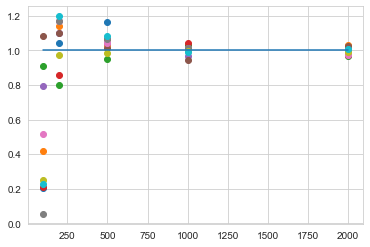

In [420]:
"""Plot results"""
plt.figure()
for n in range(len(datasizes)):
    for i in range(datasize_times):
        plt.plot(datasizes[n], models[n][i].decoder.y_nn.weight[0,1].detach().numpy(),'o')
plt.plot([datasizes[0], datasizes[-1]], 2*[c_yt])

In [413]:
%autoreload 2
BATCH_SIZE = 100
num_samples = 2000
df = linear_data_df(num_samples, c_x, c_t, c_yz, c_yt, s_x, s_t, s_y)
dataset = LinearDataset(df)
dataloader = LinearDataLoader(dataset, validation_split=0.0)
train_loader, test_loader = dataloader.get_loaders(batch_size=BATCH_SIZE)
#dummy test loader
test_loader, _ = LinearDataLoader(LinearDataset(df[:1]), validation_split=0.0).get_loaders(batch_size=1)

Training Results - Epoch 1 - y_reconc_loss: 187.1617 x_reconc_loss: 422.6119 t_reconc_loss: 188.4627 kld_loss: 130.5013 total_loss: 928.7377 learning rate: 0.0098
Training Results - Epoch 2 - y_reconc_loss: 172.3980 x_reconc_loss: 393.2727 t_reconc_loss: 173.0243 kld_loss: 71.4024 total_loss: 810.0975 learning rate: 0.0097
Training Results - Epoch 3 - y_reconc_loss: 161.9448 x_reconc_loss: 375.9682 t_reconc_loss: 161.6181 kld_loss: 42.9322 total_loss: 742.4634 learning rate: 0.0095
Training Results - Epoch 4 - y_reconc_loss: 156.3613 x_reconc_loss: 366.5524 t_reconc_loss: 155.2438 kld_loss: 27.0724 total_loss: 705.2298 learning rate: 0.0094
Training Results - Epoch 5 - y_reconc_loss: 154.0760 x_reconc_loss: 362.6929 t_reconc_loss: 152.9283 kld_loss: 17.8601 total_loss: 687.5573 learning rate: 0.0093
Training Results - Epoch 6 - y_reconc_loss: 153.5811 x_reconc_loss: 361.8550 t_reconc_loss: 152.1238 kld_loss: 12.4598 total_loss: 680.0196 learning rate: 0.0091
Training Results - Epoch 7 

Training Results - Epoch 53 - y_reconc_loss: 140.1692 x_reconc_loss: 193.3296 t_reconc_loss: 143.2312 kld_loss: 115.3402 total_loss: 592.0702 learning rate: 0.0044
Training Results - Epoch 54 - y_reconc_loss: 139.6217 x_reconc_loss: 192.5214 t_reconc_loss: 142.1138 kld_loss: 116.9342 total_loss: 591.1910 learning rate: 0.0044
Training Results - Epoch 55 - y_reconc_loss: 140.1488 x_reconc_loss: 196.0093 t_reconc_loss: 141.9240 kld_loss: 114.8394 total_loss: 592.9215 learning rate: 0.0043
Training Results - Epoch 56 - y_reconc_loss: 140.8580 x_reconc_loss: 195.5196 t_reconc_loss: 142.7405 kld_loss: 113.9935 total_loss: 593.1117 learning rate: 0.0042
Training Results - Epoch 57 - y_reconc_loss: 140.1442 x_reconc_loss: 197.0572 t_reconc_loss: 142.6494 kld_loss: 115.1796 total_loss: 595.0304 learning rate: 0.0042
Training Results - Epoch 58 - y_reconc_loss: 139.1812 x_reconc_loss: 194.5601 t_reconc_loss: 142.1312 kld_loss: 118.6224 total_loss: 594.4949 learning rate: 0.0041
Training Results

Training Results - Epoch 103 - y_reconc_loss: 140.2803 x_reconc_loss: 187.6306 t_reconc_loss: 142.8815 kld_loss: 120.9226 total_loss: 591.7149 learning rate: 0.0021
Training Results - Epoch 104 - y_reconc_loss: 140.2456 x_reconc_loss: 185.7196 t_reconc_loss: 141.9663 kld_loss: 122.1726 total_loss: 590.1041 learning rate: 0.0020
Training Results - Epoch 105 - y_reconc_loss: 140.2999 x_reconc_loss: 186.1230 t_reconc_loss: 142.1758 kld_loss: 121.6965 total_loss: 590.2951 learning rate: 0.0020
Training Results - Epoch 106 - y_reconc_loss: 140.1901 x_reconc_loss: 189.4277 t_reconc_loss: 142.0870 kld_loss: 120.0336 total_loss: 591.7385 learning rate: 0.0020
Training Results - Epoch 107 - y_reconc_loss: 140.7920 x_reconc_loss: 185.8552 t_reconc_loss: 143.2254 kld_loss: 121.3837 total_loss: 591.2563 learning rate: 0.0019
Training Results - Epoch 108 - y_reconc_loss: 140.6139 x_reconc_loss: 189.1814 t_reconc_loss: 142.4963 kld_loss: 121.5355 total_loss: 593.8271 learning rate: 0.0019
Training R

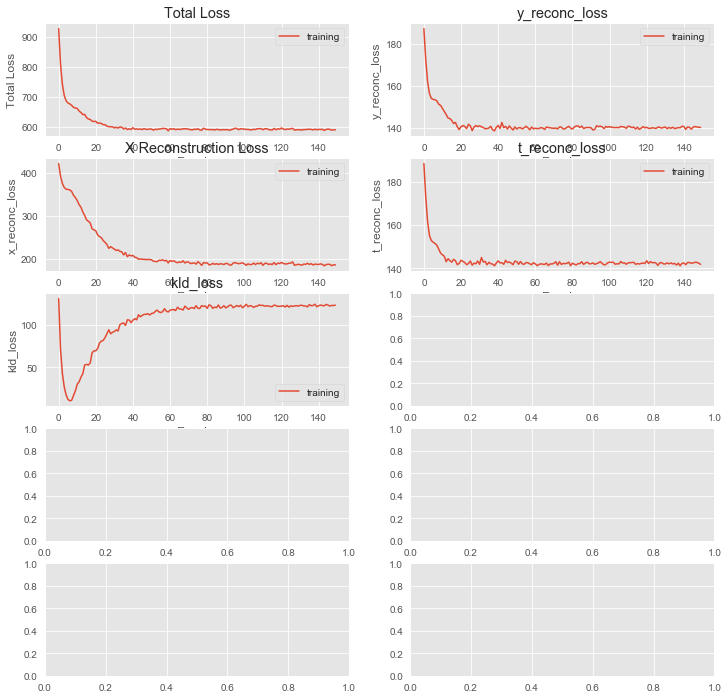

In [414]:
#Running the model
device = 'cpu'
model = run_cevae(num_epochs=150, lr_start=0.01, lr_end=0.001,
        train_loader=train_loader, test_loader=test_loader, input_dim=2,
        plot_curves=True, print_logs=True, device=device)

In [415]:
print(model.decoder.x_nns[0].weight)
print(model.decoder.x_nns[1].weight)
print(model.decoder.treatment_pred.weight)
print(model.decoder.y_nn.weight)
print(torch.exp(model.decoder.x_log_std))
print(torch.exp(model.decoder.t_log_std))
print(torch.exp(model.decoder.y_log_std))

Parameter containing:
tensor([[0.9710]], requires_grad=True)
Parameter containing:
tensor([[1.8966]], requires_grad=True)
Parameter containing:
tensor([[0.4818]], requires_grad=True)
Parameter containing:
tensor([[0.5997, 0.9689]], requires_grad=True)
tensor([0.4833, 0.7785], grad_fn=<ExpBackward>)
tensor([1.0056], grad_fn=<ExpBackward>)
tensor([0.9828], grad_fn=<ExpBackward>)


In [347]:
#model = linearCEVAE(2)

In [348]:
z_mean, z_std, x_pred, t_pred, y_pred = model(X,t,y)

tensor([[  206639.9062],
        [  520801.4688],
        [  -48078.0586],
        [  -31784.4453],
        [  548102.1250],
        [  313240.2812],
        [ -286249.2500],
        [ -121190.5312],
        [  -56753.8516],
        [  194008.0625],
        [ -200662.7500],
        [ -132585.6562],
        [  -59232.4766],
        [ -611381.1250],
        [-1042880.6875],
        [   73682.8672],
        [ -149713.9531],
        [  420027.9375],
        [ -308351.2812],
        [  182769.3438],
        [ -517588.1875],
        [ -155516.9062],
        [  479945.6562],
        [ -457238.8125],
        [   78510.5469],
        [  585677.0625],
        [ -751061.8125],
        [ -448733.0625],
        [  339960.9688],
        [ -277019.6562],
        [   39716.9297],
        [   26830.0586],
        [  -48212.1328],
        [  340881.8125],
        [  -70703.6406],
        [ -365347.7812],
        [  -88416.2188],
        [ -114065.7188],
        [  346381.7188],
        [  478239.5312],


In [304]:
print(z_mean.grad)
print(model.encoder.z_logstd.grad)

None
tensor([52.0870])
